In [1]:
!git add .
!git commit -m "Attempts to fix 3d issue with a reshape"
!git push

[main e8ba770] Attempts to fix 3d issue with a reshape
 1 file changed, 68 insertions(+), 182 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.54 KiB | 1.54 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/RudimentaryChef/FissionTrack.git
   903a357..e8ba770  main -> main


In [2]:
# Install the required libraries
#SAM
#!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
#!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
#!pip install datasets
#!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
#!pip install patchify

#!pip install matplotlib

#!pip install tifffile

#!pip install scipy


In [3]:
#Numpy for handling data in vectors, matplotlib to graph
import numpy as np
import matplotlib.pyplot as plt
#Library to work with TIFFs
import tifffile

#Importing OS for 
import os
#We are going to work with large images and patchify helps with dividing it up
import patchify as p
import scipy
from scipy import ndimage
#Random imported for sampling
import random
import cv2

In [30]:
import cv2
import numpy as np

def read_image_and_mask(image_path, mask_path):
    """
    Reads an image and a mask from the specified paths and returns them as NumPy arrays.
    
    Args:
        image_path (str): Path to the image file.
        mask_path (str): Path to the mask file.
    
    Returns:
        tuple: A tuple containing the image array and the mask array.
    """
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Reshape the grayscale image to have three channels by adding an additional dimension
    three_channel_image = np.expand_dims(gray_image, axis=-1)
    
    # Repeat the single channel across three channels to convert it to RGB format
    rgb_image = np.repeat(three_channel_image, 3, axis=-1)

    # Read the mask image using OpenCV
    mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Convert the images to NumPy arrays
    image_array = np.array(rgb_image)
    mask_array = np.array(mask_image)
    
    return image_array, mask_array

# Example usage:
image_array, mask_array = read_image_and_mask('/Users/adikrish/Desktop/Adam.jpg', '/Users/adikrish/Desktop/Eve.png')


In [32]:
import cv2
import numpy as np

def read_image_and_mask(image_path, mask_path):
    """
    Reads an image and a mask from the specified paths and returns them as NumPy arrays.
    
    Args:
        image_path (str): Path to the image file.
        mask_path (str): Path to the mask file.
    
    Returns:
        tuple: A tuple containing the image array and the mask array.
    """
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Reshape the grayscale image to have three channels by adding an additional dimension
    three_channel_image = np.expand_dims(gray_image, axis=-1)
    
    # Repeat the single channel across three channels to convert it to RGB format
    rgb_image = np.repeat(three_channel_image, 3, axis=-1)

    # Read the mask image using OpenCV
    mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Convert the images to NumPy arrays
    image_array = np.array(rgb_image)
    mask_array = np.array(mask_image)
    
    return image_array, mask_array

# Example usage:
image_array, mask_array = read_image_and_mask('/Users/adikrish/Desktop/Adam.jpg', '/Users/adikrish/Desktop/Eve.png')


In [36]:
image_array.shape

mask_array.shape

(1504, 2048)

In [6]:
#creates a step size and a patch size
patch_size = 256 
step = 256

In [7]:
import numpy as np
import patchify  # Assuming you're using the 'patchify' library for patch extraction

# Define the patch size and step size
patch_size = 256
step = 256

# Function to extract patches from an image
def extract_patches(image_array, patch_size, step):
    all_patches = []
    patches = patchify.patchify(image_array, (patch_size, patch_size), step=step)
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i, j, :, :]
            all_patches.append(patch)
    return np.array(all_patches)

# Read the image and mask
image_array, mask_array = read_image_and_mask('/Users/adikrish/Desktop/Adam.jpg', '/Users/adikrish/Desktop/Eve.png')

# Extract patches from the image
if len(image_array.shape) == 2:  # Grayscale image
    patches_img = extract_patches(image_array, patch_size, step)
else:  # RGB image
    patches_img = extract_patches(image_array[..., 0], patch_size, step)

# Extract patches from the mask
patches_mask = extract_patches(mask_array, patch_size, step)

# Preprocess the mask patches
patches_mask = (patches_mask / 255.).astype(np.uint8)

# Optionally, you can convert the list of patches to a NumPy array if needed
images = np.array(patches_img)
masks = np.array(patches_mask)


In [8]:
#we filter out of our masks any fully zero patches
valid_indices = [i for i, masks in enumerate(masks) if masks.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)
print("mask shape: ", filtered_masks.shape)

Image shape: (40, 256, 256)
mask shape:  (40, 256, 256)


In [9]:
#move it to a dataset object
from datasets import Dataset
from PIL import Image
dataset_dict = {
    'image': [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks]
}
dataset = Dataset.from_dict(dataset_dict)

In [10]:
#We only have 40 images because we only have 40 masks
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 40
})

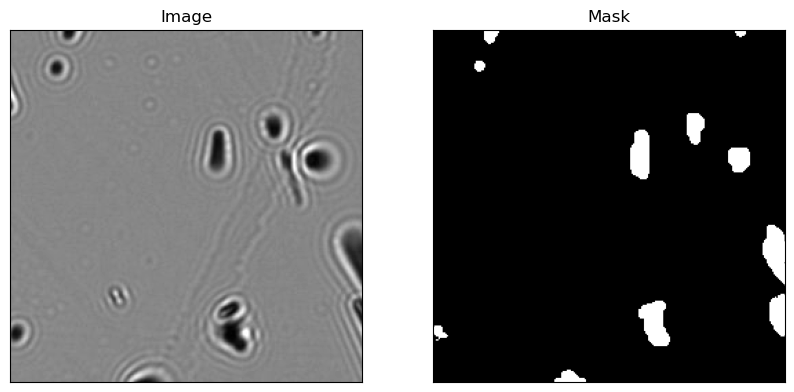

In [11]:
#A quick sanity check to see if our masks are working properly
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [12]:
#Gets a bounding box and applies it to our image
#copied directly from reference
def get_bounding_box(ground_truth_map):
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    #adds a little tolerance 
    H, W = ground_truth_map.shape
    x_min = max(0,x_min - np.random.randint(0,20))
    x_max = min(W, x_max + np.random.randint(0,20))
    y_min = max(0,y_min - np.random.randint(0,20))
    y_max = min(H, y_max + np.random.randint(0,20))
    bounding_box = [x_min,y_min,x_max,y_max]
    return bounding_box


In [13]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    """
    This class creates a dataset with input images and masks.
    Overrides the __len__ and __getitem__ methods of the Dataset class
    """
    #constructor that provides the data set and the processor
    def __init__(self,dataset,processor):
        self.dataset = dataset
        self.processor = processor
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        #gives us an image and the groundtruth box
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])
        #gives us the bounding box for the image
        prompt = get_bounding_box(ground_truth_mask)
        # prepare iamge and prompt for the model
        inputs = self.processor(image,input_boxes = [[prompt]], return_tensors = "pt")
        #removes the batch dimension (which is added by default by the processor need to look into this more)
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        #Adds ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask
        return inputs

In [14]:
#Initalizes our processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [15]:
train_dataset = SAMDataset(dataset,processor)

In [16]:
example = train_dataset

In [17]:
#We are customizing our data loader
#Put drop_last to True if you get some tensor error
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset,batch_size = 1, shuffle = True, drop_last = False)

In [27]:
# Assuming batch is a dictionary containing image data
#Use batch = next(iter(train_dataloader)) for 3d Array
len(train_dataloader)

40

In [25]:
batch = next(iter(train_dataloader))

ValueError: Unsupported number of image dimensions: 2

In [20]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")
#makes sure we only compute the gradients for what we need
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)